In [1]:
"""
Created on Thu Dec  9 13:47:49 2021

@author: 11312
"""
import tensorflow as tf
import pathlib
import sys
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import os
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
AUTOTUNE = tf.data.experimental.AUTOTUNE

import os
num_feature = 16             # number of feature maps
num_channels = 3             # number of input's channels 
patch_size = 64              # patch size 
KernelSize = 3               # kernel size 
learning_rate = 0.1          # learning rate
iterations = int(2.1*1e5)    # iterations
batch_size = 20              # batch size
image_count = 9100
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

input_path = "./TrainData/input/"
label_path = "./TrainData/label/"

test_path = "./TestData/input/"

Num GPUs Available:  1


In [2]:
def diff_x(input, r):
    assert input.shape.ndims == 4

    left   = input[:, :,         r:2 * r + 1]
    middle = input[:, :, 2 * r + 1:         ] - input[:, :,           :-2 * r - 1]
    right  = input[:, :,        -1:         ] - input[:, :, -2 * r - 1:    -r - 1]

    output = tf.concat([left, middle, right], axis=2)

    return output


def diff_y(input, r):
    assert input.shape.ndims == 4

    left   = input[:, :, :,         r:2 * r + 1]
    middle = input[:, :, :, 2 * r + 1:         ] - input[:, :, :,           :-2 * r - 1]
    right  = input[:, :, :,        -1:         ] - input[:, :, :, -2 * r - 1:    -r - 1]

    output = tf.concat([left, middle, right], axis=3)

    return output


def box_filter(x, r):
    assert x.shape.ndims == 4

    return diff_y(tf.cumsum(diff_x(tf.cumsum(x, axis=2), r), axis=3), r)


def guided_filter(x, y, r, eps=1e-8, nhwc=False):
    assert x.shape.ndims == 4 and y.shape.ndims == 4

    # data format
    if nhwc:
        x = tf.transpose(x, [0, 3, 1, 2])
        y = tf.transpose(y, [0, 3, 1, 2])

    # shape check
    x_shape = tf.shape(x)
    y_shape = tf.shape(y)

    assets = [tf.assert_equal(   x_shape[0],  y_shape[0]),
              tf.assert_equal(  x_shape[2:], y_shape[2:]),
              tf.assert_greater(x_shape[2:],   2 * r + 1),
              tf.Assert(tf.logical_or(tf.equal(x_shape[1], 1),
                                      tf.equal(x_shape[1], y_shape[1])), [x_shape, y_shape])]

    with tf.control_dependencies(assets):
        x = tf.identity(x)

    # N
    N = box_filter(tf.ones((1, 1, x_shape[2], x_shape[3]), dtype=x.dtype), r)

    # mean_x
    mean_x = box_filter(x, r) / N
    # mean_y
    mean_y = box_filter(y, r) / N
    # cov_xy
    cov_xy = box_filter(x * y, r) / N - mean_x * mean_y
    # var_x
    var_x  = box_filter(x * x, r) / N - mean_x * mean_x

    # A
    A = cov_xy / (var_x + eps)
    # b
    b = mean_y - A * mean_x

    mean_A = box_filter(A, r) / N
    mean_b = box_filter(b, r) / N

    output = mean_A * x + mean_b

    if nhwc:
        output = tf.transpose(output, [0, 2, 3, 1])

    return output

def _parse_function(filename, label):  
     
    image_string = tf.io.read_file(filename)  
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)  
    rainy = tf.cast(image_decoded, tf.float32)/255.0
  
  
    image_string = tf.io.read_file(label)  
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)  
    label = tf.cast(image_decoded, tf.float32)/255.0
    
    t = time.time()
    rainy = tf.image.random_crop(rainy, [patch_size, patch_size ,3],seed = t)   # randomly select patch
    label = tf.image.random_crop(label, [patch_size, patch_size ,3],seed = t) 

    return rainy, label

In [3]:
AllName = os.listdir(input_path)
AllLabel = os.listdir(label_path)
RainName = AllName[0:image_count]
LabelName = AllLabel[0:image_count]

print(len(RainName))

for i in range(len(RainName)):
    RainName[i] = input_path + RainName[i]
    LabelName[i] = label_path + LabelName[i]

RainName[1]

9100


'./TrainData/input/100_10.jpg'

In [4]:

image_ds = tf.convert_to_tensor(RainName, dtype=tf.string) 
label_ds = tf.convert_to_tensor(LabelName, dtype=tf.string)
image_label_ds = tf.data.Dataset.from_tensor_slices((image_ds, label_ds))
ds = image_label_ds.map(_parse_function)

all_rainy_image = np.empty([image_count,64,64,3])
all_label_image = np.empty([image_count,64,64,3])

i = 0
for image_data,label_data in ds.take(image_count):
    all_rainy_image[i] = image_data.numpy()
    all_label_image[i] = label_data.numpy()
    i+=1

with tf.device('/CPU:0'):
    rainy_tensor = tf.convert_to_tensor(all_rainy_image)
    detail_tensor = rainy_tensor - guided_filter(rainy_tensor,rainy_tensor,15,1,nhwc=True)    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Num GPUs Available:  1


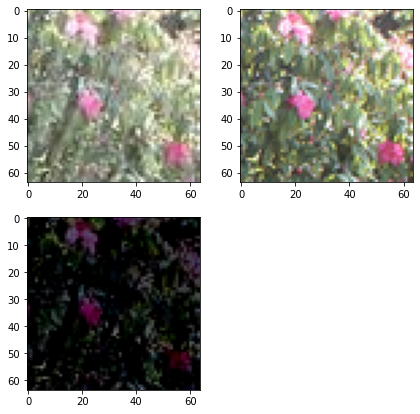

In [6]:

i = 23
plt.figure(figsize=[7,7])
plt.subplot(2,2,1)
plt.imshow(all_rainy_image[i])
plt.subplot(2,2,2)
plt.imshow(all_label_image[i])
plt.subplot(2,2,3)
plt.imshow(detail_tensor[i])
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [7]:
input = tf.keras.Input(shape=(patch_size, patch_size, 3))
detail = tf.keras.Input(shape=(patch_size, patch_size, 3))

# layer1 

x = layers.Conv2D(filters = num_feature, kernel_size = KernelSize, activation=None, padding="same", kernel_regularizer = tf.keras.regularizers.l2())(detail)
x = layers.BatchNormalization()(x)
x_shortcut = layers.ReLU()(x)

# layer 2 to 25
for i in range(12):
    x = layers.Conv2D(filters = num_feature, kernel_size = KernelSize, activation=None, padding="same", kernel_regularizer = tf.keras.regularizers.l2())(x_shortcut)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters = num_feature, kernel_size = KernelSize, activation=None, padding="same", kernel_regularizer = tf.keras.regularizers.l2())(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x_shortcut = tf.add(x_shortcut,x)
# layer 26

x = layers.Conv2D(filters = num_channels, kernel_size = KernelSize, activation=None, padding="same", kernel_regularizer = tf.keras.regularizers.l2())(x_shortcut)
neg_residual = layers.BatchNormalization()(x)

final_out = tf.add(input,neg_residual)

# model compile
model = Model([input,detail], final_out)

step = tf.Variable(0, trainable=False)
boundaries = [1000, 2e5]
values = [0.1, 0.01, 0.0001]
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)
opti = tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum = 0.9)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr
lr_metric = get_lr_metric(opti)

model.compile(loss="mse", optimizer=opti, metrics=['accuracy', lr_metric],)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   448         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 64, 64, 16)   0           ['batch_normalization[0][0]']

In [8]:
label_tensor = tf.convert_to_tensor(all_label_image)
model.fit(
    x=[rainy_tensor,detail_tensor],
    y=label_tensor,
    epochs=10,
    batch_size=20,
    shuffle=True,
   # validation_data=(image_batch, label_batch),
)
model.save('my_model/')

Epoch 1/10
455/455 [==============================] - 26s 39ms/step - loss: 0.2720 - accuracy: 0.7967 - lr: 0.1000
Epoch 2/10
455/455 [==============================] - 17s 37ms/step - loss: 0.0040 - accuracy: 0.8169 - lr: 0.1000
Epoch 3/10
455/455 [==============================] - 17s 37ms/step - loss: 0.0034 - accuracy: 0.8173 - lr: 0.0278
Epoch 4/10
455/455 [==============================] - 17s 37ms/step - loss: 0.0031 - accuracy: 0.8171 - lr: 0.0100
Epoch 5/10
455/455 [==============================] - 17s 37ms/step - loss: 0.0030 - accuracy: 0.8169 - lr: 0.0100
Epoch 6/10
455/455 [==============================] - 17s 37ms/step - loss: 0.0029 - accuracy: 0.8167 - lr: 0.0100
Epoch 7/10
455/455 [==============================] - 17s 37ms/step - loss: 0.0029 - accuracy: 0.8165 - lr: 0.0100
Epoch 8/10
455/455 [==============================] - 17s 37ms/step - loss: 0.0029 - accuracy: 0.8162 - lr: 0.0100
Epoch 9/10
455/455 [==============================] - 17s 37ms/step - loss: 0.00

In [9]:
predictions = model.predict([rainy_tensor,detail_tensor])
predictions.shape

(9100, 64, 64, 3)

<function matplotlib.pyplot.show(close=None, block=None)>

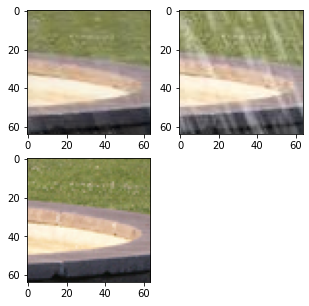

In [17]:
plt.figure(figsize=[5,5])
ii = 1123

plt.subplot(2,2,1)
plt.imshow(predictions[ii])
plt.subplot(2,2,2)
plt.imshow(all_rainy_image[ii])
plt.subplot(2,2,3)
plt.imshow(all_label_image[ii])
plt.show

In [21]:
im1 = tf.image.convert_image_dtype(predictions[ii], tf.float32)
im2 = tf.image.convert_image_dtype(all_rainy_image[ii], tf.float32)
ssim = tf.image.ssim(im1, im2, max_val=1.0, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)

In [22]:
ssim

<tf.Tensor: shape=(), dtype=float32, numpy=0.8403409>